In [1]:
"""

snipper.io/s/-MSTCnlcnC3p7aUSnOm_
https://www.kaggle.com/c/clickbait-news-detection/

"""

'\n\nsnipper.io/s/-MSTCnlcnC3p7aUSnOm_\nhttps://www.kaggle.com/c/clickbait-news-detection/\n\n'

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
from copy import deepcopy

from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram, HashingTF, IDF, CountVectorizer, StringIndexer #Word2Vec, OneHotEncoder, RegexTokenizer,
from pyspark.sql.functions import col, udf, length, avg, lit, concat, size, array, countDistinct
from pyspark.sql.types import IntegerType, StringType, ArrayType
#from pyspark.mllib.classification import NaiveBayes#, NaiveBayesModel
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import SparkSession

import re
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
#import nltk
#nltk.download('wordnet')

In [4]:
try:
    sc.stop()
except:
    print("no sc to stop")

In [5]:
conf = SparkConf().setAppName('clickbait').setMaster('local[2]')
sc = SparkContext.getOrCreate(conf = conf)

In [6]:
spark = SparkSession.builder.appName('ClickBait')\
    .config("spark.driver.memory", "8g")\
    .config("spark.executor.memory", "2g")\
    .getOrCreate()

In [7]:
spark

In [8]:
train_path = "file:///home/hadoop/data/clickbait/train.csv"
#train_path = "hdfs://localhost:9000/data/train.csv;"

In [9]:
# load main training dataframe

t_df = spark.read.csv(train_path, header=True, inferSchema=True, encoding="utf-8")

t_df=t_df.filter((t_df.label == "news")|(t_df.label == "clickbait"))

t_df.persist()

DataFrame[id: string, title: string, text: string, label: string]

In [10]:
t_df.select("label").distinct().show(), t_df.count()

+---------+
|    label|
+---------+
|     news|
|clickbait|
+---------+



(None, 11875)

In [11]:
t_df.filter((t_df.label == "news")).count(),t_df.filter((t_df.label == "clickbait")).count(),

(9371, 2504)

In [12]:
t_df=t_df.na.drop()

t_df.persist()

DataFrame[id: string, title: string, text: string, label: string]

In [13]:
t_df.count()

11807

In [14]:
news_df = t_df.select("*").where(col('label')=="news")
cb_df = t_df.select("*").where(col('label')=="clickbait")

In [15]:
news_df.count(), cb_df.count()

(9327, 2480)

In [16]:
news_seed=4
news_df=news_df.sample(withReplacement=None, fraction=1.0, seed=news_seed).select("*").limit(int(cb_df.count())) # seed selection -9

In [17]:
news_df=news_df.sample(withReplacement=None, fraction=1.0, seed=news_seed).select("*").limit(1600) # 1600
cb_df=cb_df.sample(withReplacement=None, fraction=1.0, seed=news_seed).select("*").limit(1600)

In [18]:
news_df.count(), cb_df.count()

(1600, 1600)

In [19]:
t_df = news_df.union(cb_df)
t_df.persist()
t_df.count()

3200

In [20]:
# Helper UDF functions to remove possessive S and special chars
#from string import punctuation
# def strip_possessive(l_):
#     ptrn=re.compile(r"['`’]s", flags=re.I)
#     r__ = [ptrn.sub('', s_) for s_ in l_]
#     return(r__)  

@udf("string")
def strip_possessive_str(s_):
    ptrn=re.compile(r"['`’]s", flags=re.I)
    r__ = ptrn.sub(' ', s_)
    return(r__)


###
# def strip_func(l_):
#     ptrn = re.compile('[\W_]+')
#     r__ = [ptrn.sub('', s_) for s_ in l_]
#     return(r__)

@udf("string")
def strip_func_str(s_):
    ptrn = re.compile('[\W_]+')
    r__ = ptrn.sub(' ', s_)
    return(r__)

#x = ["World's fair", "Biden's administration", "fergi's song", "Xi's policy"]

In [21]:
stemmer=SnowballStemmer("english")

lemmatizer = WordNetLemmatizer()

def stem_lem_per_word(word, pos='n'):
    sl_word = stemmer.stem(word)
    sl_word = lemmatizer.lemmatize(sl_word, pos=pos)
    return(sl_word)
    #pos=noun
    

def stem_lem_list(list_of_words, pos='n'):
    # l_ is supposed to be a  column value but nltk stemmers are expecting just a python list?
    r_list = [stem_lem_per_word(w_) for w_ in list_of_words]
    r_list = [w_ for w_ in r_list if w_ not in [""]]
    return(r_list)

@udf("array<string>")
def stem_lem(arr_str):
#    pass
     return stem_lem_list(arr_str)


st_cases=["writing", "write", "wrote", "writing", "written", "drag", "dragged", "drug", "dragon", ""]
[stem_lem_per_word(case) for case in st_cases]
#t_df.select("s3").map(stem_lem)
stem_lem_list(st_cases)

['write',
 'write',
 'wrote',
 'write',
 'written',
 'drag',
 'drag',
 'drug',
 'dragon']

In [22]:
t_df.columns, t_df

(['id', 'title', 'text', 'label'],
 DataFrame[id: string, title: string, text: string, label: string])

In [23]:
t_df.select('title','text','label').limit(20).show()


+--------------------+--------------------+-----+
|               title|                text|label|
+--------------------+--------------------+-----+
|China and Economi...|Economists genera...| news|
|Trade to Be a Big...|LONDON—British Pr...| news|
|Surgeon claiming ...|An Italian neuros...| news|
|This Is How Diffe...|Spanx does not do...| news|
|Samantha Bee and ...|“Jane Pauley! You...| news|
|$94.4m $198m $112...|In the very best ...| news|
|The fabulous life...|Madeline Stone un...| news|
|President Donald ...|The Super Bowl ch...| news|
|Freddie Flintoff ...|Stephen Manderson...| news|
|Air Force Airlift...|In a much needed ...| news|
|EXCLUSIVE: 'I'm n...|The man volunteer...| news|
|Bill Seeks to Enl...|Though she had pr...| news|
|Watch E! News Now...| Deck the halls,...| news|
|Joe Scarborough: ...|First lady Melani...| news|
|ECB Stimulus Disa...|European Central ...| news|
|Tweak It or Junk ...|President Donald ...| news|
|Detroit’s Resurge...|DETROIT—Concerns ...| news|


# Text preprocessing

In [24]:
# Concatenate title & text fields
# strip_possessive_str : remove possessive s --> "`s", "'s'", "`s"...
# strip_func_str       : remove special characters --> "!","$","."...
t_df=t_df.withColumn("s", 
                strip_func_str(strip_possessive_str(
                    concat(col('title'),col("text")))
                              ))
# t_df = t_df.withColumn("s", strip_func_str(strip_possessive_str(
#     concat(col('title'),col("text")))))

In [25]:
t_df.select('s').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
t_df.columns

['id', 'title', 'text', 'label', 's']

In [27]:
selection = ['s', "title", "text"]

display("avg string length of columns")

t_df \
    .select(*(length(col(c)).alias(c) for c in selection)) \
    .agg(*(avg(col(c)).alias(c) for c in selection)).show()


'avg string length of columns'

+-----------+-------+---------+
|          s|  title|     text|
+-----------+-------+---------+
|3499.689375|73.2125|3539.1875|
+-----------+-------+---------+



In [28]:
from collections.abc import Iterable

def get_avg_len_cols(df, selection):
    """for str length in pyspark columns"""
    return(
        df \
        .select(*(length(col(c)).alias(c) for c in selection)) \
        .agg(*(avg(col(c)).alias(c) for c in selection)).show()
              )

def get_avg_size_cols(df, selection):
    """for arrays of str in pyspark df"""
    assert isinstance(selection, Iterable)
    return(
        df \
        .select(*(size(col(c)).alias(c) for c in selection)) \
        .agg(*(avg(col(c)).alias(c) for c in selection)).show()
              )

In [29]:
t_df.columns
#get_avg_size_cols

['id', 'title', 'text', 'label', 's']

In [30]:
get_avg_len_cols(t_df, ["title", "text", "s"])

+-------+---------+-----------+
|  title|     text|          s|
+-------+---------+-----------+
|73.2125|3539.1875|3499.689375|
+-------+---------+-----------+



In [31]:
# Tokenize string to list
t_df = Tokenizer(inputCol = "s", outputCol = "s1").transform(t_df) # first text transformation is pyspark builtin tokenizer


In [32]:
t_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)
 |-- s: string (nullable = true)
 |-- s1: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [33]:
t_df.select("s1").limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
dir(StopWordsRemover())

stopwords_pyspark = StopWordsRemover().getStopWords()

stopwords_from_intersection_most_common_1grams=['000',
 '1',
 '10',
 '2',
 '2017',
 '3',
 'according',
 'also',
 'another',
 'around',
 'back',
 'best',
 'company',
 'day',
 'even',
 'every',
 'first',
 'get',
 'go',
 'going',
 'good',
 'home',
 'house',
 'know',
 'last',
 'life',
 'like',
 'long',
 'm',
 'made',
 'make',
 'many',
 'may',
 'million',
 'mr',
 'much',
 'need',
 'new',
 'news',
 'next',
 'old',
 'one',
 'people',
 'percent',
 'president',
 're',
 'right',
 'said',
 'say',
 'says',
 'see',
 'show',
 'since',
 'state',
 'still',
 'take',
 'think',
 'three',
 'time',
 'times',
 'told',
 'trump',
 'twitter',
 'two',
 'u',
 'us',
 'want',
 'way',
 'week',
 'well',
 'women',
 'work',
 'world',
 'year',
 'years']

In [35]:
display(len(stopwords_pyspark))
stopwords_pyspark+=[w for w in stopwords_from_intersection_most_common_1grams]
display(len(stopwords_pyspark))

181

256

In [36]:
#t_df = StopWordsRemover(inputCol = "s1", outputCol="s2", stopWords=stopwords_pyspark).transform(t_df)
t_df = StopWordsRemover(inputCol = "s1", outputCol="s2").transform(t_df)



In [37]:
display("difference in avg word array len after StopWordsRemover.transform")
get_avg_size_cols(t_df, ['s1','s2'])

'difference in avg word array len after StopWordsRemover.transform'

+-----------+-----------+
|         s1|         s2|
+-----------+-----------+
|616.2259375|359.0196875|
+-----------+-----------+



In [38]:
t_df.sample(False, 0.1, seed=0).select("s2").limit(1).show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|s2                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
+-----------------------------------------------------------------------------

In [39]:
#t_df=t_df.withColumn("s3",stem_lem("s2")) # current stem_lem approach is not helping accuracy
t_df=t_df.withColumn("s3", col("s2"))

In [40]:
t_df.select("s3").take(3)



[Row(s3=['china', 'economic', 'reform', 'xi', 'jinping', 'track', 'record', 'economists', 'generally', 'agree', 'china', 'must', 'overhaul', 'huge', 'wasteful', 'economy', 'wants', 'continue', 'grow', 'years', 'come', 'means', 'limiting', 'political', 'interference', 'banking', 'financial', 'system', 'making', 'bloated', 'industries', 'sensitive', 'market', 'forces', 'lowering', 'barriers', 'foreign', 'trade', 'investment', 'proponents', 'took', 'heart', 'late', '2012', 'president', 'xi', 'jinping', 'took', 'formal', 'control', 'chinese', 'communist', 'party', 'pledges', 'crack', 'corruption', 'cut', 'red', 'tape', 'today', 'mr', 'xi', 'nears', 'end', 'first', 'five', 'year', 'term', 'much', 'optimism', 'among', 'economists', 'faded', 'china', 'remains', 'heavily', 'dependent', 'large', 'investments', 'maintained', 'brisk', 'slowing', 'economic', 'growth', 'steep', 'rise', 'government', 'steered', 'lending', 'still', 'administration', 'made', 'small', 'changes', 'hints', 'mr', 'xi', 'm

### Assign n-gram columns

In [41]:
from pyspark.ml import Pipeline

ngram_pipeline=Pipeline(stages=[NGram(n=i, inputCol="s3", outputCol= str(i)+"gram") for i in range(1,4)])
m = ngram_pipeline.fit(t_df)
t_df = m.transform(t_df)
t_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)
 |-- s: string (nullable = true)
 |-- s1: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- s2: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- s3: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- 1gram: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- 2gram: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- 3gram: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [42]:
t_df.select("1gram","2gram","3gram").take(3)

[Row(1gram=['china', 'economic', 'reform', 'xi', 'jinping', 'track', 'record', 'economists', 'generally', 'agree', 'china', 'must', 'overhaul', 'huge', 'wasteful', 'economy', 'wants', 'continue', 'grow', 'years', 'come', 'means', 'limiting', 'political', 'interference', 'banking', 'financial', 'system', 'making', 'bloated', 'industries', 'sensitive', 'market', 'forces', 'lowering', 'barriers', 'foreign', 'trade', 'investment', 'proponents', 'took', 'heart', 'late', '2012', 'president', 'xi', 'jinping', 'took', 'formal', 'control', 'chinese', 'communist', 'party', 'pledges', 'crack', 'corruption', 'cut', 'red', 'tape', 'today', 'mr', 'xi', 'nears', 'end', 'first', 'five', 'year', 'term', 'much', 'optimism', 'among', 'economists', 'faded', 'china', 'remains', 'heavily', 'dependent', 'large', 'investments', 'maintained', 'brisk', 'slowing', 'economic', 'growth', 'steep', 'rise', 'government', 'steered', 'lending', 'still', 'administration', 'made', 'small', 'changes', 'hints', 'mr', 'xi',

In [43]:
#Label indexer

indexer = StringIndexer(inputCol="label", outputCol="label_index")
t_df = indexer.fit(t_df).transform(t_df)
t_df.persist()

DataFrame[id: string, title: string, text: string, label: string, s: string, s1: array<string>, s2: array<string>, s3: array<string>, 1gram: array<string>, 2gram: array<string>, 3gram: array<string>, label_index: double]

In [44]:
# Lines to save preprocessed dataframe to disk or hdfs

PREPROCESSED_DF_CSV_PATH="file:///home/hadoop/cb/pre_train.csv"

#t_df.repartition(1).write.format('com.databricks.spark.csv').save(PREPROCESSED_DF_CSV_PATH,header = 'true')

#t_df.repartition(1).write.json(PREPROCESSED_DF_CSV_PATH,mode="overwrite")

t_df.schema

StructType(List(StructField(id,StringType,true),StructField(title,StringType,true),StructField(text,StringType,true),StructField(label,StringType,true),StructField(s,StringType,true),StructField(s1,ArrayType(StringType,true),true),StructField(s2,ArrayType(StringType,true),true),StructField(s3,ArrayType(StringType,true),true),StructField(1gram,ArrayType(StringType,false),true),StructField(2gram,ArrayType(StringType,false),true),StructField(3gram,ArrayType(StringType,false),true),StructField(label_index,DoubleType,false)))

In [45]:
t_df.columns

['id',
 'title',
 'text',
 'label',
 's',
 's1',
 's2',
 's3',
 '1gram',
 '2gram',
 '3gram',
 'label_index']

# ML Pipeline

In [46]:
train, test = t_df.randomSplit([.8,.2], seed = 2) #news_seed 4, train/test seed 999, accuracy 1.0??

In [47]:
# 1-gram, 2-gram, 3-gram
gramcols=["1gram", "2gram", "3gram"]
pipeline = Pipeline(stages=[CountVectorizer(inputCol=c__ , outputCol=c__+"_cv", minDF=2.0) for c__ in gramcols] +
                    [NaiveBayes(modelType= "multinomial", labelCol="label_index",
                                featuresCol = c__ + "_cv",
                                rawPredictionCol="raw_pred_" + c__,
                                probabilityCol="prob_"+c__,
                                predictionCol="pred_"+c__) for c__ in gramcols]
                   )

In [48]:
pipeline_model = pipeline.fit(train)
pred = pipeline_model.transform(test)

# Classifier Accuracy

In [49]:

evaluator = MulticlassClassificationEvaluator(labelCol= "label_index", predictionCol = "pred_1gram", 
                                              metricName="accuracy")
evaluator0 = MulticlassClassificationEvaluator(labelCol= "label_index", predictionCol = "pred_2gram", 
                                              metricName="accuracy")
evaluator1 = MulticlassClassificationEvaluator(labelCol= "label_index", predictionCol = "pred_3gram", 
                                              metricName="accuracy")

#nb_accuracy = evaluator.evaluate(nb_predictions)
nb_accuracy = evaluator.evaluate(pred)
nb_accuracy0 = evaluator0.evaluate(pred)
nb_accuracy1 = evaluator1.evaluate(pred)

print("1gram Accuracy : ", nb_accuracy)
print("2gram Accuracy : ", nb_accuracy0)
print("3gram Accuracy : ", nb_accuracy1)

#news seed 2: 0.68
#news seed 3: 0.68
#news seed 4: 0.68

1gram Accuracy :  0.6666666666666666
2gram Accuracy :  0.6975308641975309
3gram Accuracy :  0.6311728395061729


In [50]:
t_df.where(col("label")=="news").select('1gram')

DataFrame[1gram: array<string>]

In [51]:
from pyspark.sql.functions import explode

def token_freqs_to_pandas(df,label_equals,select_col):
    pass


news_1grams_pandas = t_df.where(col("label")=="news").withColumn('word', explode(col('1gram')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .toPandas()

cb_1grams_pandas = t_df.where(col("label")=="clickbait").withColumn('word', explode(col('1gram')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .toPandas()


In [52]:
news_2grams_pandas = t_df.where(col("label")=="news").withColumn('word', explode(col('2gram')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .toPandas()

cb_2grams_pandas = t_df.where(col("label")=="clickbait").withColumn('word', explode(col('2gram')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .toPandas()

In [53]:
news_2grams_pandas,cb_2grams_pandas

(                            word  count
 0                          pm et    879
 1                    white house    561
 2                       new york    496
 3                       mr trump    453
 4                  united states    401
 5                   donald trump    392
 6                       year old    391
 7                      last year    283
 8       washington correspondent    229
 9                    twitter com    218
 10                   pic twitter    215
 11               president trump    214
 12                  social media    201
 13                    super bowl    186
 14                    york times    177
 15                alan rappeport    176
 16          rappeport washington    175
 17                     years ago    174
 18                    first time    168
 19               president elect    158
 20                   health care    156
 21                     last week    150
 22                prime minister    139
 23             

In [54]:
display(cb_1grams_pandas.iloc[:100].word.values,
news_1grams_pandas.iloc[:100].word.values,)

top_100_tokens_intersection=set(news_1grams_pandas.iloc[:100].word.values).intersection( set(cb_1grams_pandas.iloc[:100].word.values))

top_100_tokens_intersection

array(['said', 'one', 'trump', 'people', 'new', 'like', 'breitbart',
       'year', 'also', 'time', 'get', 're', 'first', '2017', 'years',
       'make', 'even', 'made', 'two', 'day', 'facebook', '1', 'many',
       'president', 'may', 'way', 'world', 'last', 'us', 'know', 'back',
       'says', 'see', 'life', '2', 'much', 'best', 'state', '5', 'work',
       'take', '3', '10', 'want', '2016', 'good', 'com', 'news', 'well',
       'going', 'twitter', 'm', 'think', 've', 'go', '000', 'big', 'old',
       'still', 'need', 'women', 'home', 'house', 'since', 'right',
       'told', 'according', 'full', 'around', 'three', 'mr', 'every',
       'say', 'u', '4', 'week', 'd', 'really', 'send', 'look', 'help',
       'times', '6', 'long', 'million', 'things', 'show', 'another',
       'use', 'percent', 'tip', 'company', 'copyright', 'high', 'never',
       'got', 'll', 'great', 'next', 'something'], dtype=object)

array(['said', 'trump', 'one', 'new', 'people', 'year', 'also',
       'president', 'like', 'first', 'mr', 'time', 'two', 'years', 'et',
       'last', '1', 'us', 'world', 'u', 'house', 'may', 'even', 'pm',
       'get', 're', 'white', 'back', 'government', 'many', 'state', 'day',
       'made', 'news', 'says', 'since', '2', 'told', 'going', 'make',
       'way', 'twitter', '000', '10', 'three', 'police', 'think', 'still',
       'm', 'percent', 'according', 'say', 'much', 'obama', 'see',
       'country', 'old', 'know', 'work', 'family', 'take', 'well',
       'women', 'week', 'around', '2017', 'united', 'american',
       'washington', 'long', 'states', 'right', 'times', 'man', 'show',
       'national', 'best', 'company', 'including', 'life', 'home', 'good',
       'go', 'another', 'city', '3', 'former', 'million', 'part', 'found',
       'public', 'media', 'business', 'every', 'york', 'health',
       'campaign', 'want', 'next', 'need'], dtype=object)

{'000',
 '1',
 '10',
 '2',
 '2017',
 '3',
 'according',
 'also',
 'another',
 'around',
 'back',
 'best',
 'company',
 'day',
 'even',
 'every',
 'first',
 'get',
 'go',
 'going',
 'good',
 'home',
 'house',
 'know',
 'last',
 'life',
 'like',
 'long',
 'm',
 'made',
 'make',
 'many',
 'may',
 'million',
 'mr',
 'much',
 'need',
 'new',
 'news',
 'next',
 'old',
 'one',
 'people',
 'percent',
 'president',
 're',
 'right',
 'said',
 'say',
 'says',
 'see',
 'show',
 'since',
 'state',
 'still',
 'take',
 'think',
 'three',
 'time',
 'times',
 'told',
 'trump',
 'twitter',
 'two',
 'u',
 'us',
 'want',
 'way',
 'week',
 'well',
 'women',
 'work',
 'world',
 'year',
 'years'}

In [55]:
import wordcloud

In [56]:
stopwords = wordcloud.STOPWORDS
display(len(stopwords))
stopwords= stopwords.union(top_100_tokens_intersection)
stopwords= stopwords.union(set(stopwords_pyspark))
display(len(stopwords))

display(top_100_tokens_intersection)

192

268

{'000',
 '1',
 '10',
 '2',
 '2017',
 '3',
 'according',
 'also',
 'another',
 'around',
 'back',
 'best',
 'company',
 'day',
 'even',
 'every',
 'first',
 'get',
 'go',
 'going',
 'good',
 'home',
 'house',
 'know',
 'last',
 'life',
 'like',
 'long',
 'm',
 'made',
 'make',
 'many',
 'may',
 'million',
 'mr',
 'much',
 'need',
 'new',
 'news',
 'next',
 'old',
 'one',
 'people',
 'percent',
 'president',
 're',
 'right',
 'said',
 'say',
 'says',
 'see',
 'show',
 'since',
 'state',
 'still',
 'take',
 'think',
 'three',
 'time',
 'times',
 'told',
 'trump',
 'twitter',
 'two',
 'u',
 'us',
 'want',
 'way',
 'week',
 'well',
 'women',
 'work',
 'world',
 'year',
 'years'}

In [57]:
import matplotlib.pyplot as plt

In [58]:
def wc_func(pandas_df):
    freqs=pandas_df.set_index("word").to_dict()['count']
    wc_r = wordcloud.WordCloud(width = 1600, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10)\
    .generate_from_frequencies(frequencies=freqs)    
    plt.figure(figsize=(16,8))
    plt.imshow(wc_r)
    plt.show()
    return

# wc_news = wordcloud.WordCloud(width = 1600, height = 800, 
#                 background_color ='black', 
#                 stopwords = stopwords, 
#                 min_font_size = 10)

# wc_news.generate_from_frequencies(frequencies=news_1grams_pandas.set_index("word").to_dict()['count'])

# plt.figure(figsize=(16,8))
# plt.imshow(wc_news)
# plt.show()

# Most common 1-grams

"Top 1-grams from 'news' label"

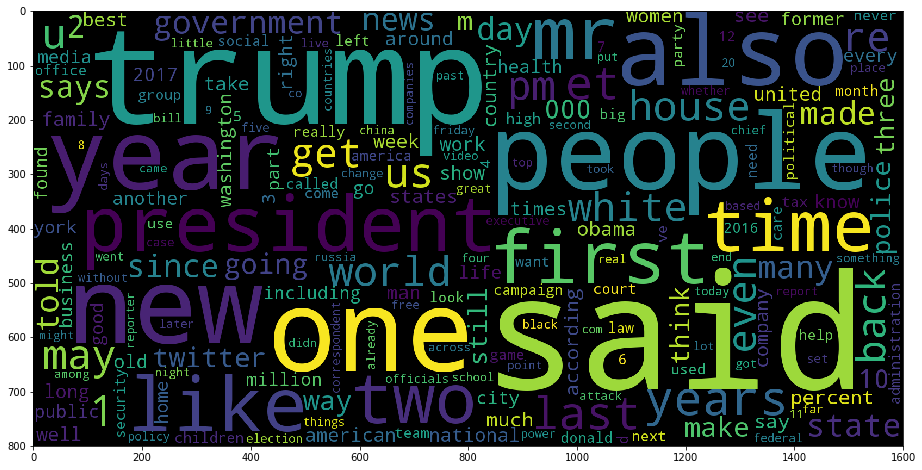

In [59]:
display("Top 1-grams from 'news' label")

wc_func(news_1grams_pandas)



"Top 1-grams from 'clickbait' label"

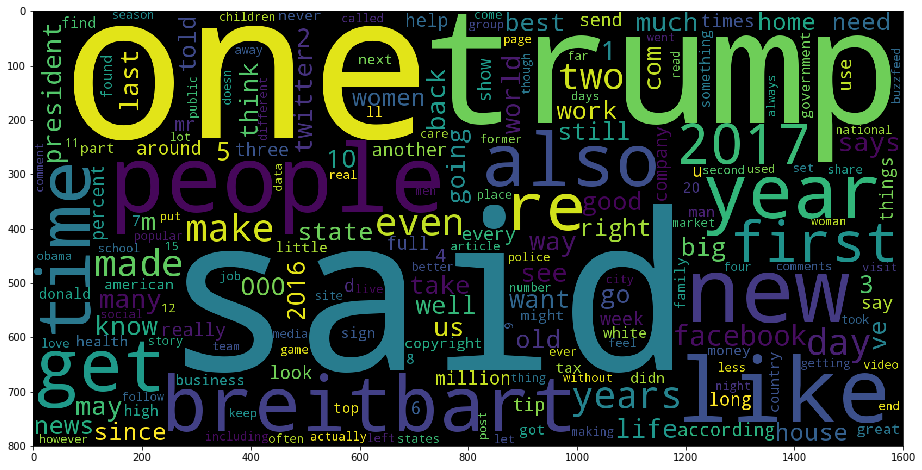

In [60]:
display("Top 1-grams from 'clickbait' label")

wc_func(cb_1grams_pandas)



# Most common 2-grams

"Top 2-grams in 'news' label"

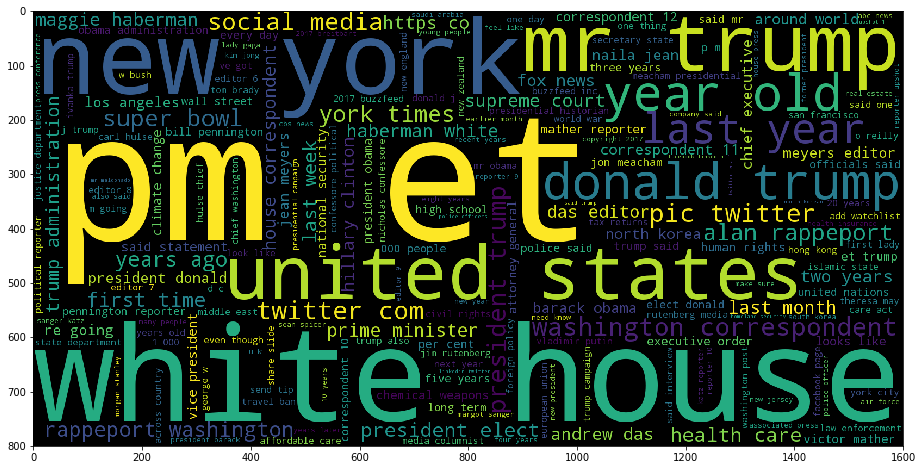

In [61]:
display("Top 2-grams in 'news' label")
wc_func(news_2grams_pandas)

"Top 2-grams in 'clickbait' label"

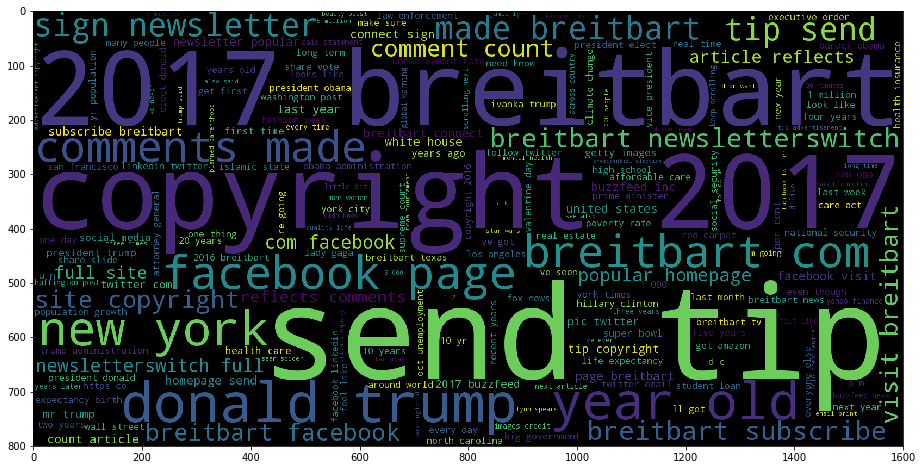

In [62]:
display("Top 2-grams in 'clickbait' label")
wc_func(cb_2grams_pandas)